# Correlation Analytics --- The Phillips curve

## Background

<p>The Phillips curve is an economic concept developed by A. W. Phillips describing the inverse relationship between unemployment rate and inflation rate within an economy. It states that economic growth brings inflation, leading to more jobs and hence lower unemployment rate.</p><br>
This report is going to validate this relationship using historical data in Hong Kong.

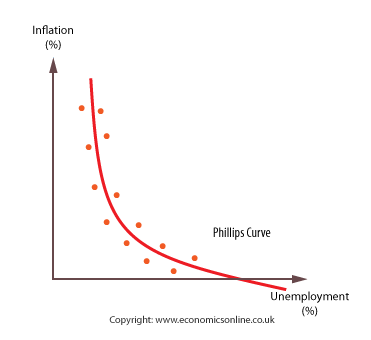

In [89]:
from IPython.display import Image
Image('Source Data\\Phillips-curve-basic.png')

Source:<ul>
<li>http://www.investopedia.com/terms/p/phillipscurve.asp</li>
<li>https://en.wikipedia.org/wiki/Phillips_curve</li>
</ul>

## Data Extraction and Transformation

### Data Extraction

Inflation Rate:<br>
<p>Source: https://data.gov.hk/en-data/dataset/hk-censtatd-tablechart-cpi/resource/927b192b-83ff-4c45-aa5a-cd970d6274a1<br>
This dataset contains the average monthly rate of change (%) of consumer price indices (CPI) during the latest 3 months from 1981 to 2017. There are 4 CPIs in the dataset. The CPI(A), CPI(B) and CPI(C) are compiled based on expenditure patterns of households (low, medium and high expenditure groups). The composite CPI aggregates the expenditure patterns covered by the above 3 indices, therefore it can better represent the whole household sector. In this report, the composite CPI will be used for estimating the true inflation rate of Hong Kong.</p>
<br>
Unemplotment Rate:<br>
<p>Source: https://data.gov.hk/en-data/dataset/hk-censtatd-tablechart-statistics-on-labour-force-unemployment-and-underemployment/resource/6f1045ff-097d-402a-9586-abba49cf468a<br>
This dataset contains the unemployment rate in 3-month period from 1982 to 2017. Since the seasonally adjusted CPI rate of change is used, the seasonally adjusted unemployment rate is also used in this report.</p>




### Data Transformation

In [90]:
# Import Pandas for data manipulation
import pandas as pd
# Set global display option
pd.options.display.max_rows = 15
# use pandas library to read excel file
df_cpi = pd.read_excel('Source Data\\Consumer Price Index.xlsx', parse_cols="A:C", skip_rows=3, header=3).iloc[0:439]
# display output
df_cpi

,Year,Month,Composite Consumer Price Index
0,1981,Jan,N.A.
1,NaN,Feb,N.A.
2,NaN,Mar,N.A.
3,NaN,Apr,N.A.
4,NaN,May,N.A.
5,NaN,Jun,N.A.
6,NaN,Jul,N.A.
...,...,...,...
432,2017,Jan,0.1
433,NaN,Feb,-0.1


As the Year Column is incomplete, it is needed to fill it in.

In [91]:
# Fill Year Column
Year = [int(df_cpi.Year.values[0])]
for i in range(1, len(df_cpi.index)):
	Year.append(Year[i-1] + int((i)%12==0))
df_cpi['Year'] = Year
df_cpi

,Year,Month,Composite Consumer Price Index
0,1981,Jan,N.A.
1,1981,Feb,N.A.
2,1981,Mar,N.A.
3,1981,Apr,N.A.
4,1981,May,N.A.
5,1981,Jun,N.A.
6,1981,Jul,N.A.
...,...,...,...
432,2017,Jan,0.1
433,2017,Feb,-0.1


In order to estimate the inflation rate, the year-to-year rate of change of CPI is used. In this dataset, the rate of change is on monthly basis. Some steps are involved for this data conversion.

In [92]:
# Import numpy for calculation
import numpy as np
# Drop rows with value 'n.a'
df_cpi = df_cpi[df_cpi['Composite Consumer Price Index']!='N.A.']
df_cpi = df_cpi.reset_index(drop=True)
# From % to float
df_cpi['Composite Consumer Price Index'] = df_cpi['Composite Consumer Price Index']/100 + 1
# Prepare array of yearly rate
cpi_monthly = list(df_cpi['Composite Consumer Price Index'].values)
cpi_yearly = []
for i in range(0, len(cpi_monthly)):
	if i <= 10:
		continue
	else:
		cpi_yearly.append(np.product(cpi_monthly[i-11:i+1])-1)
# Drop first 11 rows and monthly rate column
df_cpi = df_cpi.iloc[11:len(df_cpi)]
df_cpi = df_cpi.drop('Composite Consumer Price Index',axis=1)
df_cpi = df_cpi.reset_index(drop=True)
# Copy array to dataframe
df_cpi['cpi_yearly'] = cpi_yearly
# Display Output
df_cpi

,Year,Month,cpi_yearly
0,1992,Dec,0.094879
1,1993,Jan,0.094879
2,1993,Feb,0.093793
3,1993,Mar,0.090545
4,1993,Apr,0.086226
5,1993,May,0.086226
6,1993,Jun,0.087304
...,...,...,...
289,2017,Jan,0.011030
290,2017,Feb,0.006998


Now the period is splited into two columns (Year and Month). These columns are merged into a column "Period" and stored in standard Python datetime format.

In [93]:
# Import Calendar and datetime library for converting data into standard datetime format
import calendar
import datetime

# Function to get last day of month of a year
def get_datetime(Year, Month):
	return datetime.date(int(Year),int(Month),calendar.monthrange(int(Year),int(Month))[1])

# Convert month appreviation to integer (e.g. "Dec" -> 12)
df_cpi['Month'] = df_cpi['Month'].apply(lambda x : list(calendar.month_abbr).index(x))
# Get the date using get_datetime function defined above
df_cpi['Date'] = df_cpi.apply(lambda row: get_datetime(row['Year'],row['Month']), axis=1)
df_cpi = df_cpi.drop(['Month','Year'],axis=1)
#Display Output
df_cpi

,cpi_yearly,Date
0,0.094879,1992-12-31
1,0.094879,1993-01-31
2,0.093793,1993-02-28
3,0.090545,1993-03-31
4,0.086226,1993-04-30
5,0.086226,1993-05-31
6,0.087304,1993-06-30
...,...,...
289,0.011030,2017-01-31
290,0.006998,2017-02-28


For cleansing another dataset, steps such as removing trailing special characters, getting datetime and unit conversion are involved.

In [94]:
# Import Regular Expression libray for string manipulation
import re
# Starting from row 169 as only data from 31-12-1992 to 31-07-2017 are needed
df_unemployment_rate = pd.read_excel('Source Data\\Unemployment Rate.xlsx', parse_cols="A,F", header=3).iloc[169:465]
df_unemployment_rate = df_unemployment_rate.reset_index(drop=True)
# Remove trailing space and other characters
df_unemployment_rate['Period'] = df_unemployment_rate['Period'].apply(lambda x: re.sub(r"[#@ .*]",r"",x))
# Get DateTime
df_unemployment_rate['Period'] = df_unemployment_rate['Period'].apply(lambda x: get_datetime(int(x.split('-')[1].split('/')[1]),int(x.split('-')[1].split('/')[0])))
# Rename the columns
df_unemployment_rate.columns = ['Date','Unemployment Rate']
# Change percentage to float
df_unemployment_rate['Unemployment Rate'] = df_unemployment_rate['Unemployment Rate'].apply(lambda x : float(x)/100)
# Display Output
df_unemployment_rate

,Date,Unemployment Rate
0,1992-12-31,0.024
1,1993-01-31,0.022
2,1993-02-28,0.022
3,1993-03-31,0.021
4,1993-04-30,0.019
5,1993-05-31,0.018
6,1993-06-30,0.018
...,...,...
289,2017-01-31,0.033
290,2017-02-28,0.033


The two cleansed datasets are then merged into a single dataset and the final dataset is stored in .csv format.

In [95]:
# Merge the two datasets
df_clean = df_cpi.merge(df_unemployment_rate)
# Output dataset as csv
df_clean.to_csv('Source Data\\data_cleaned.csv')
# Display Output
df_clean

,cpi_yearly,Date,Unemployment Rate
0,0.094879,1992-12-31,0.024
1,0.094879,1993-01-31,0.022
2,0.093793,1993-02-28,0.022
3,0.090545,1993-03-31,0.021
4,0.086226,1993-04-30,0.019
5,0.086226,1993-05-31,0.018
6,0.087304,1993-06-30,0.018
...,...,...,...
289,0.011030,2017-01-31,0.033
290,0.006998,2017-02-28,0.033


# Data Analysis

## Scattered Plot

As the first step, a scattered plot is used to display the relationship between unemployment rate and inflation rate.